# Email Spam Detection Using ML and Ensemble of Electra Transformers

GROUP 3


# DATA EXPLORATION AND PRE PROCESSING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import all libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import string
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from gensim.models import Word2Vec, FastText
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
warnings.filterwarnings('ignore')

In [ ]:
#creating word cloud for given corpus  
def make_wordcloud(corpus , stopword):
    word_cloud = WordCloud(
            width=3000,
            height=2000,
            random_state=1,
            background_color="black",
            colormap="Pastel1",
            collocations=False,
            stopwords=stopword,
            ).generate(corpus)
    return word_cloud

In [ ]:
#This function swaps 2 columns inside the dataframe
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [ ]:
#This function removes punctuation from string
def remove_punctuations(text):
    
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
        
    return text

In [ ]:
#Reading dataset
Email_dataset = pd.read_csv("/content/drive/MyDrive/Bracu/Spring2023/spam_ham_dataset.csv")

In [ ]:
#Show dataset
Email_dataset.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
s=Email_dataset["label"].value_counts()
s

ham     3672
spam    1499
Name: label, dtype: int64

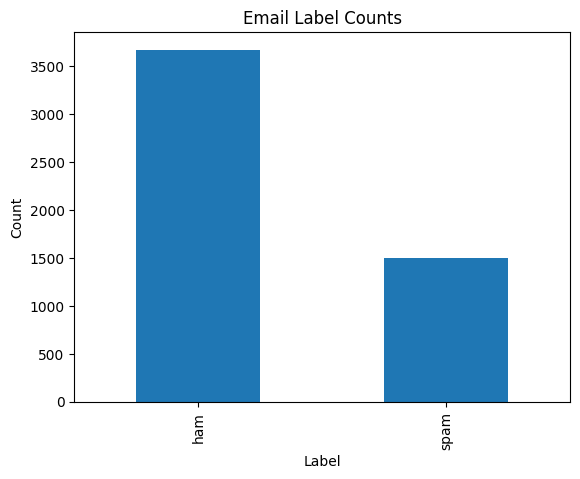

In [ ]:
# create a bar chart
s.plot.bar()

# set the title and axis labels
plt.title("Email Label Counts")
plt.xlabel("Label")
plt.ylabel("Count")

# display the chart
plt.show()

In [ ]:
#Dropping columns that are not needed
Email_dataset = Email_dataset.drop('Unnamed: 0', axis=1)
Email_dataset = Email_dataset.drop('label', axis=1)

In [ ]:
Email_dataset.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
Email_dataset.keys()

Index(['text', 'label_num'], dtype='object')

In [ ]:
#Creating a new feature, extracting subject of each email
subjects = []
for i in range(len(Email_dataset)):
    ln = Email_dataset["text"][i]
    line = ""
    for s in ln:
        if(s == '\r'):
            break
        line = line + s
    line = line.replace("Subject" , "")
    subjects.append(line)

In [ ]:
Email_dataset['Subject'] = subjects

In [ ]:
#Renaming the dataframe columns
Email_dataset.columns = ["Email_text" , "Labels" , "Email_Subject"]

In [ ]:
Email_dataset.head()

,Email_text,Labels,Email_Subject
0,Subject: enron methanol ; meter # : 988291\r\n...,0,: enron methanol ; meter # : 988291
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,": hpl nom for january 9 , 2001"
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,: neon retreat
3,"Subject: photoshop , windows , office . cheap ...",1,": photoshop , windows , office . cheap . main ..."
4,Subject: re : indian springs\r\nthis deal is t...,0,: re : indian springs


In [ ]:
#Swapping the dataframe columns 
Email_dataset = swap_columns(Email_dataset, 'Labels', 'Email_Subject')

In [ ]:
Email_dataset.head()

,Email_text,Email_Subject,Labels
0,Subject: enron methanol ; meter # : 988291\r\n...,: enron methanol ; meter # : 988291,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",": hpl nom for january 9 , 2001",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",: neon retreat,0
3,"Subject: photoshop , windows , office . cheap ...",": photoshop , windows , office . cheap . main ...",1
4,Subject: re : indian springs\r\nthis deal is t...,: re : indian springs,0


In [ ]:
#Converting all strings to lowercase
Email_dataset['Email_Subject'] = Email_dataset['Email_Subject'].str.lower()
Email_dataset['Email_text'] = Email_dataset['Email_text'].str.lower()

In [ ]:
#Removing Punctuation from the data
Email_dataset['Email_Subject'] = Email_dataset['Email_Subject'].apply(remove_punctuations)
Email_dataset['Email_text'] = Email_dataset['Email_text'].apply(remove_punctuations)

In [ ]:
Email_dataset.head()

,Email_text,Email_Subject,Labels
0,subject enron methanol meter 988291\r\nthis...,enron methanol meter 988291,0
1,subject hpl nom for january 9 2001\r\n see at...,hpl nom for january 9 2001,0
2,subject neon retreat\r\nho ho ho we re aroun...,neon retreat,0
3,subject photoshop windows office cheap mai...,photoshop windows office cheap main trending,1
4,subject re indian springs\r\nthis deal is to ...,re indian springs,0


In [ ]:
#Creting seprate dataset for Spam and Non Spam emails, to perform analysis 
Spam = pd.DataFrame(columns = ['Email_text', 'Email_Subject', 'Labels'])
Non_Spam = pd.DataFrame(columns = ['Email_text', 'Email_Subject', 'Labels'])

In [ ]:
#Creating Non_Spam email dataset 
for i in range(len(Email_dataset)):
    if(Email_dataset['Labels'][i] == 0):
        new_row = {'Email_text':Email_dataset['Email_text'][i], 'Email_Subject':Email_dataset['Email_Subject'][i], 'Labels':Email_dataset['Labels'][i]}
        Non_Spam = Non_Spam.append(new_row, ignore_index=True)

In [ ]:
#Creating Spam email dataset 
for i in range(len(Email_dataset)):
    if(Email_dataset['Labels'][i] == 1):
        new_row = {'Email_text':Email_dataset['Email_text'][i], 'Email_Subject':Email_dataset['Email_Subject'][i], 'Labels':Email_dataset['Labels'][i]}
        Spam = Spam.append(new_row, ignore_index=True)

In [ ]:
Spam.head()

,Email_text,Email_Subject,Labels
0,subject photoshop windows office cheap mai...,photoshop windows office cheap main trending,1
1,subject looking for medication we re the bes...,looking for medication we re the best source,1
2,subject vocable rnd word asceticism\r\nvcsc ...,vocable rnd word asceticism,1
3,subject report 01405 \r\nwffur attion brom est...,report 01405,1
4,subject vic odin n ow\r\nberne hotbox carnal...,vic odin n ow,1


In [ ]:
Non_Spam.head()

,Email_text,Email_Subject,Labels
0,subject enron methanol meter 988291\r\nthis...,enron methanol meter 988291,0
1,subject hpl nom for january 9 2001\r\n see at...,hpl nom for january 9 2001,0
2,subject neon retreat\r\nho ho ho we re aroun...,neon retreat,0
3,subject re indian springs\r\nthis deal is to ...,re indian springs,0
4,subject ehronline web address change\r\nthis m...,ehronline web address change,0


In [ ]:
#creating stopwords corpus
more_stopwords = {'re' , 's' , 'subject','hpl','hou','enron'}
STOPWORDS = STOPWORDS.union(more_stopwords)

In [ ]:
#creating spam subject corpus 
Subject_corpus_spam = ""
for i in range(len(Spam)):
    Subject_corpus_spam = Subject_corpus_spam + Spam['Email_Subject'][i]
    

In [ ]:
#creating spam text corpus 
Text_corpus_spam = ""
for i in range(len(Spam)):
    Text_corpus_spam = Text_corpus_spam + Spam['Email_text'][i]
    

In [ ]:
#creating non-spam subject corpus 
Subject_corpus_non_spam = ""
for i in range(len(Non_Spam)):
    Subject_corpus_non_spam = Subject_corpus_non_spam + Non_Spam['Email_Subject'][i]

In [ ]:
#creating non-spam text corpus 
Text_corpus_non_spam = ""
for i in range(len(Non_Spam)):
    Text_corpus_non_spam = Text_corpus_non_spam + Non_Spam['Email_text'][i]

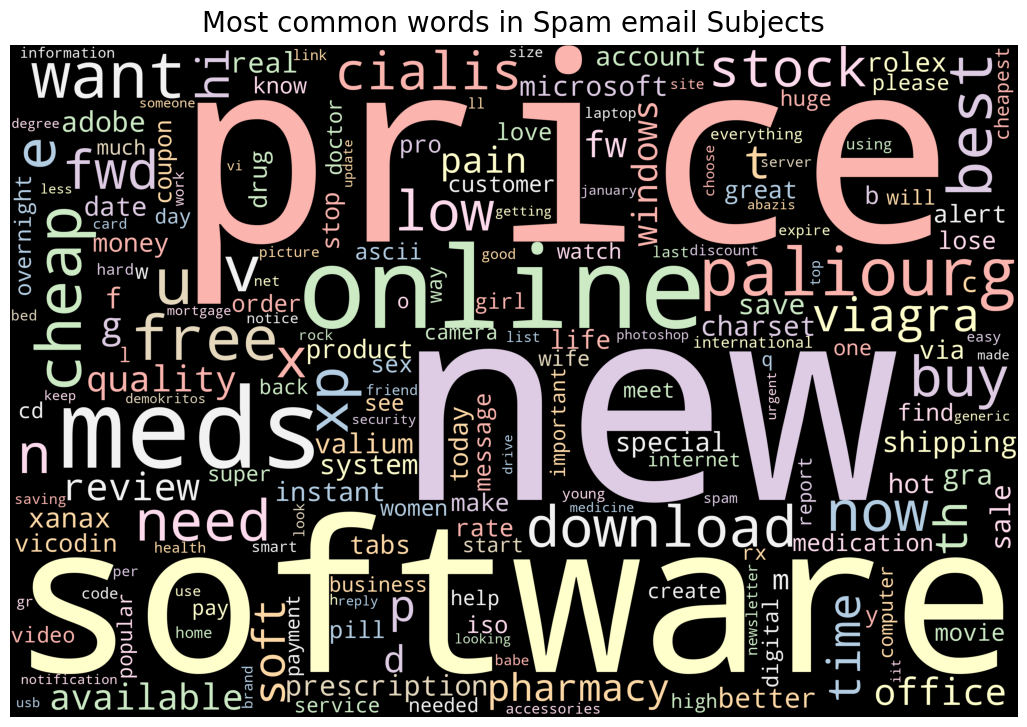

In [ ]:
#plotting word cloud for Spam Subject corpus
Spam_Subject_wordcloud = make_wordcloud (Subject_corpus_spam , STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in Spam email Subjects", fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.imshow(Spam_Subject_wordcloud)
plt.axis("off")
plt.show()

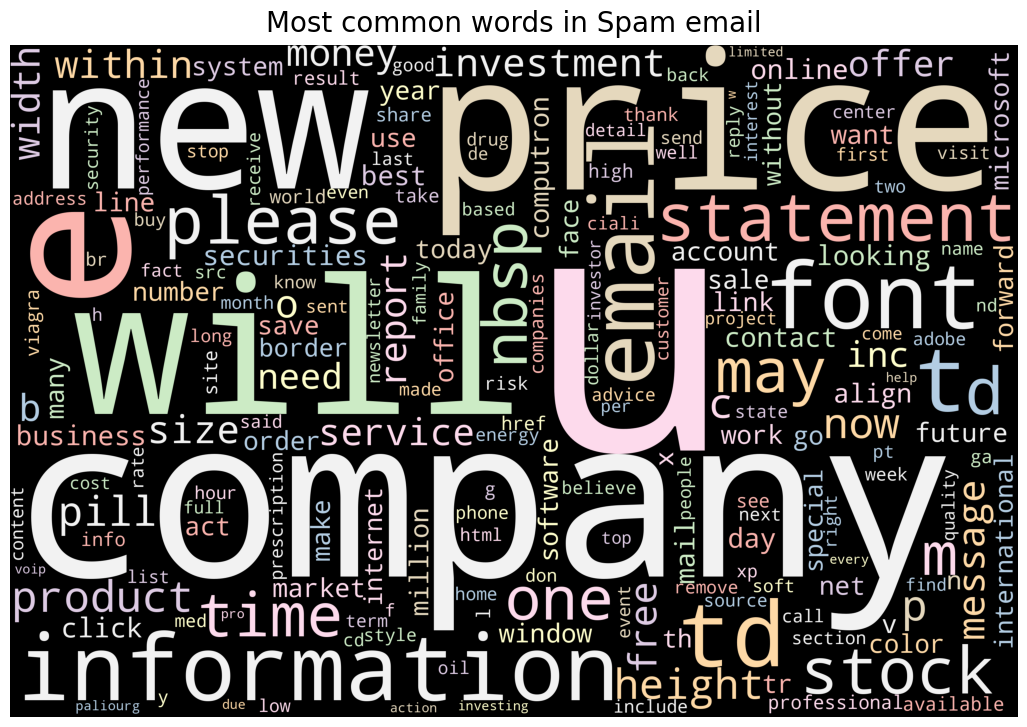

In [ ]:
#plotting word cloud for Spam Text corpus
Spam_Text_wordcloud = make_wordcloud (Text_corpus_spam , STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in Spam email", fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.imshow(Spam_Text_wordcloud)
plt.axis("off")
plt.show()

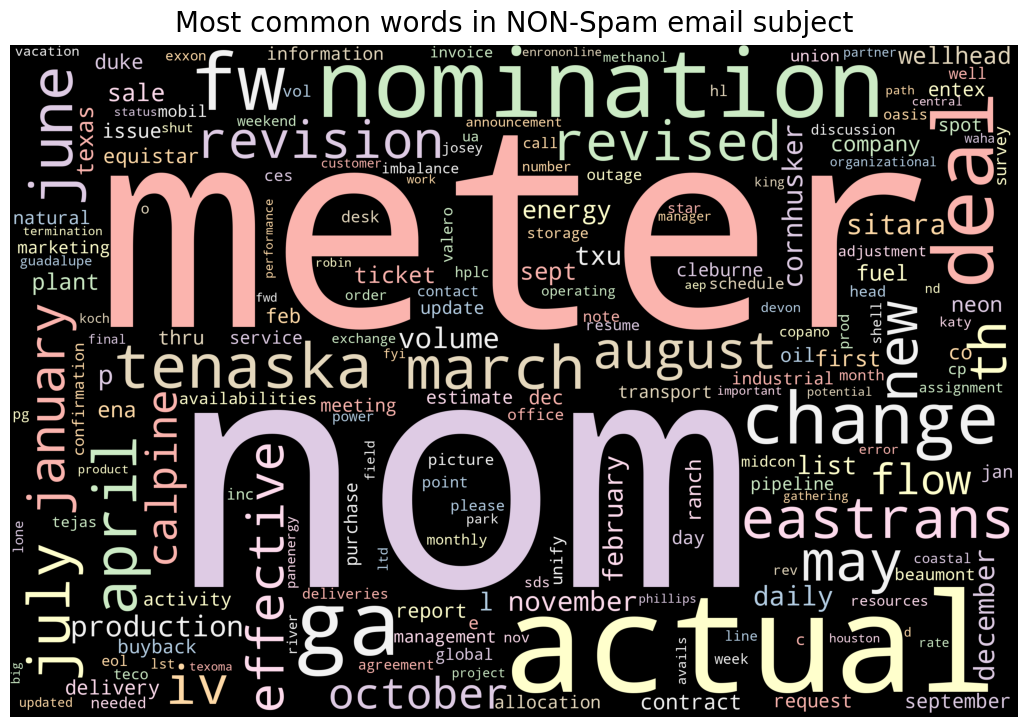

In [ ]:
 #plotting word cloud for Non Spam Subject corpus
Non_Spam_Subject_wordcloud = make_wordcloud (Subject_corpus_non_spam , STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in NON-Spam email subject", fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.imshow(Non_Spam_Subject_wordcloud)
plt.axis("off")
plt.show()

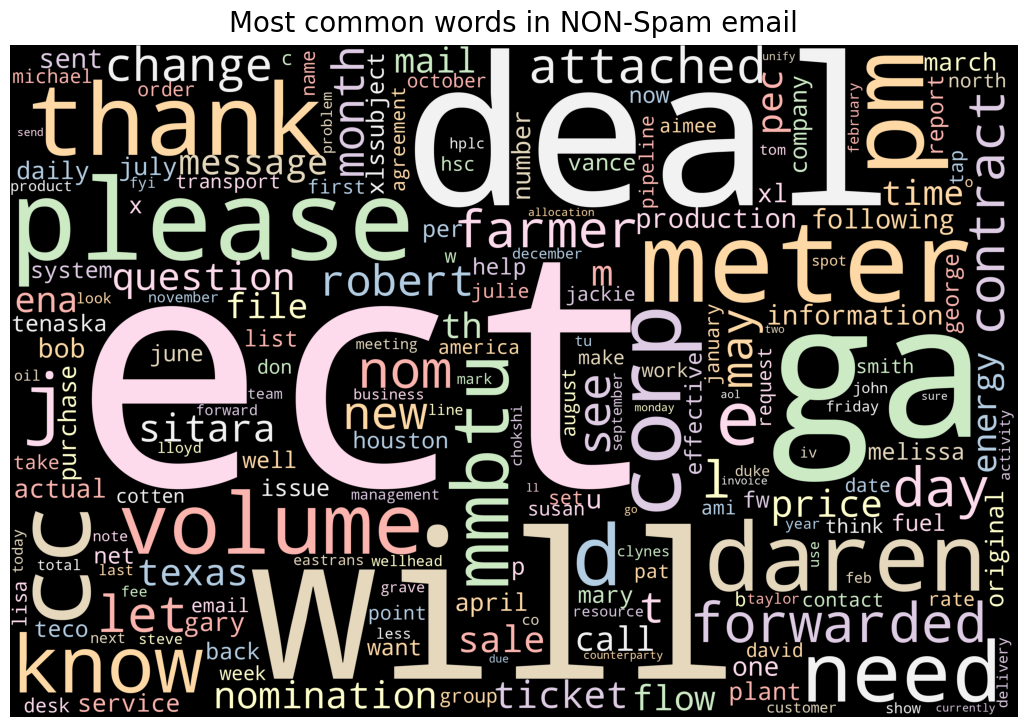

In [ ]:
#plotting word cloud for Non Spam Text corpus
Non_Spam_Subject_wordcloud = make_wordcloud (Text_corpus_non_spam , STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in NON-Spam email", fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.imshow(Non_Spam_Subject_wordcloud)
plt.axis("off")
plt.show()

In [ ]:
Email_dataset.head()

,Email_text,Email_Subject,Labels
0,subject enron methanol meter 988291\r\nthis...,enron methanol meter 988291,0
1,subject hpl nom for january 9 2001\r\n see at...,hpl nom for january 9 2001,0
2,subject neon retreat\r\nho ho ho we re aroun...,neon retreat,0
3,subject photoshop windows office cheap mai...,photoshop windows office cheap main trending,1
4,subject re indian springs\r\nthis deal is to ...,re indian springs,0


In [ ]:
#split email dataset 
X_train, X_test , y_train, y_test = train_test_split(Email_dataset['Email_text'], Email_dataset['Labels'] , test_size=0.2, random_state=42)

In [ ]:
y_test.value_counts()

0    742
1    293
Name: Labels, dtype: int64

In [ ]:
#vectorize our training dataset 
Vectorizer = CountVectorizer()
count= Vectorizer.fit_transform(X_train.values)

#Naive Bayes

In [ ]:
#fit the dataset on multinomial naive bayes 
model_NB = MultinomialNB()
targets = y_train.values
model_NB.fit(count, targets)

MultinomialNB()

In [ ]:
#make predictions and accuracy 
y_predict = model_NB.predict(Vectorizer.transform(X_test))

print(accuracy_score(y_test, y_predict))

print(classification_report(y_test , y_predict))

0.9719806763285024
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       742
           1       0.96      0.95      0.95       293

    accuracy                           0.97      1035
   macro avg       0.97      0.96      0.97      1035
weighted avg       0.97      0.97      0.97      1035



Text(50.722222222222214, 0.5, 'Actual')

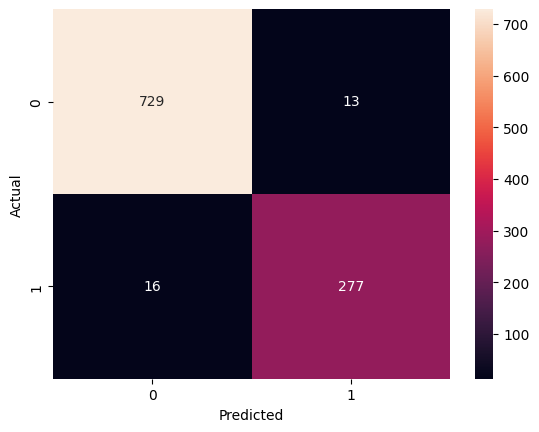

In [ ]:
#create a confusion matrix 
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#LOGISTIC REGRESSION


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#fit the dataset on multinomial naive bayes 
model_LR = LogisticRegression()
targets = y_train.values
model_LR.fit(count, targets)

LogisticRegression()

In [ ]:
#make predictions and accuracy 
y_predict = model_LR.predict(Vectorizer.transform(X_test))

print(accuracy_score(y_test, y_predict))

print(classification_report(y_test , y_predict))

0.9806763285024155
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.97      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



Text(50.722222222222214, 0.5, 'Actual')

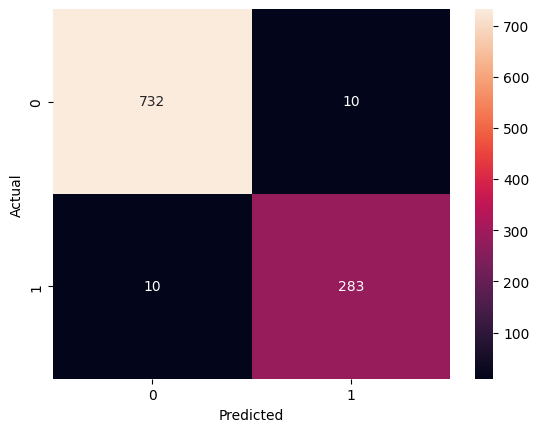

In [ ]:
#create a confusion matrix 
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
#fit the dataset on multinomial naive bayes 
model_RF = RandomForestClassifier(n_estimators=200)
targets = y_train.values
model_RF.fit(count, targets)

RandomForestClassifier(n_estimators=200)

In [ ]:
#make predictions and accuracy 
y_predict = model_RF.predict(Vectorizer.transform(X_test))

print(accuracy_score(y_test, y_predict))

print(classification_report(y_test , y_predict))

0.9739130434782609
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       742
           1       0.96      0.95      0.95       293

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



Text(50.722222222222214, 0.5, 'Actual')

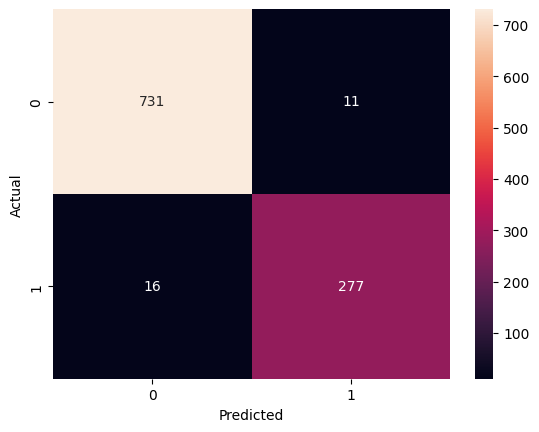

In [ ]:
#create a confusion matrix 
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#ENSEMBLE OF SUPERVISED MODEL

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
#fit the dataset on multinomial naive bayes 
model_ENS = VotingClassifier(estimators=[ ('linearRegression', model_LR), ('Random Forest', model_RF), ('Naive Bayes', model_NB)])
targets = y_train.values
model_ENS.fit(count, targets)

VotingClassifier(estimators=[('linearRegression', LogisticRegression()),
                             ('Random Forest',
                              RandomForestClassifier(n_estimators=200)),
                             ('Naive Bayes', MultinomialNB())])

In [ ]:
#make predictions and accuracy 
y_predict = model_ENS.predict(Vectorizer.transform(X_test))

print(accuracy_score(y_test, y_predict))

print(classification_report(y_test , y_predict))

0.9874396135265701
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.98      0.98       293

    accuracy                           0.99      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.99      0.99      0.99      1035



Text(50.722222222222214, 0.5, 'Actual')

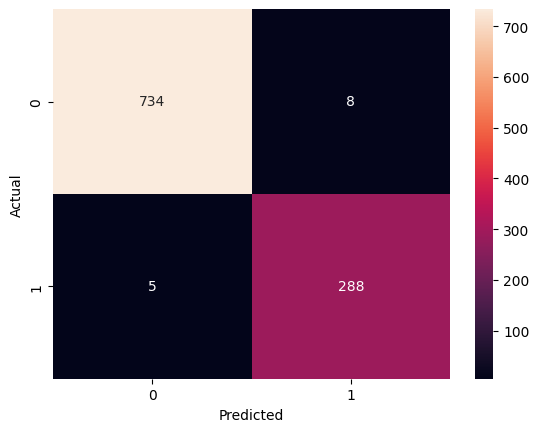

In [ ]:
#create a confusion matrix 
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#BiLSTM

In [ ]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import LSTM, GRU
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.utils import resample

In [ ]:
Y = pd.get_dummies(Email_dataset['Labels']).values
print("Shape of label tensor:", Y.shape)

Shape of label tensor: (5171, 2)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(Email_dataset['Email_text'], Y, train_size=.8, random_state=42, shuffle = True)

In [ ]:
maxlen = 800
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Email_dataset['Email_text'])

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)

X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
def create_embedding_matrix(filepath, word_idx, embedding_dim):
    vocab_size = len(word_idx) + 1  
    emb = np.zeros((vocab_size, embedding_dim))
    with open(filepath, 'r', encoding="utf8") as f:
        for i in f:
            x = i.split(' ')
            w, v = x[0], x[1:]
            if w in word_idx:
                emb[word_idx[w]] = np.asarray(v)[:embedding_dim]
    return emb

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/Bracu/Spring2022/CSE440/Project/Dataset/glove.840B.300d.txt', tokenizer.word_index, embedding_dim)


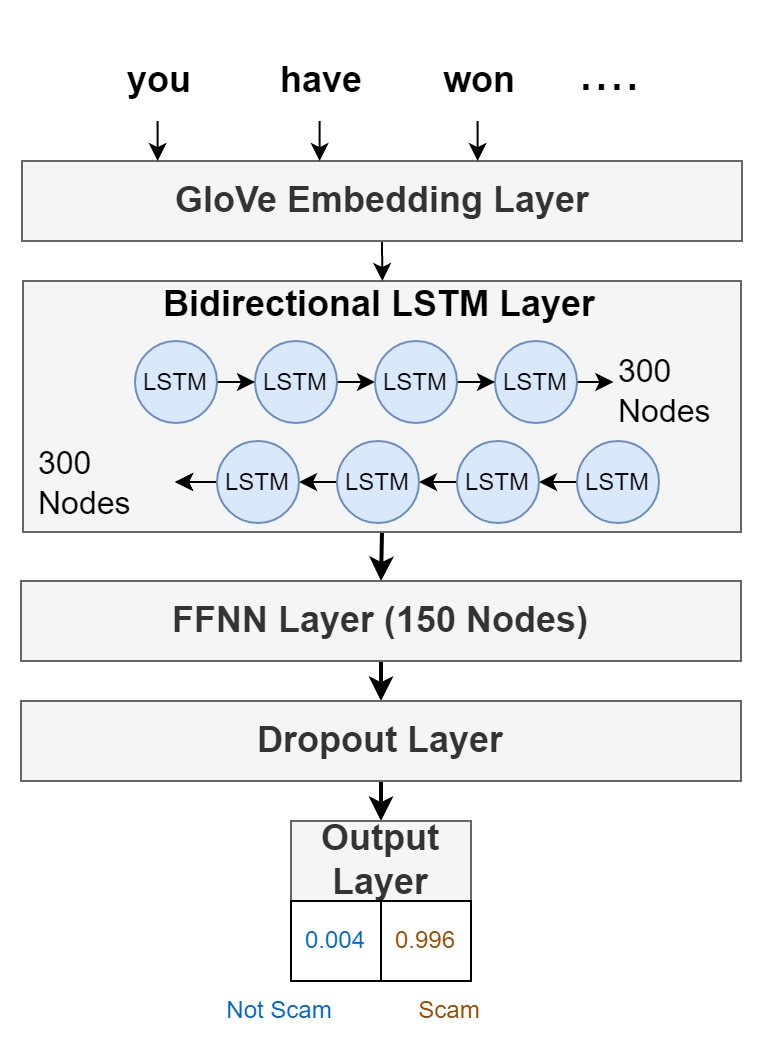

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                          weights=[embedding_matrix], 
                          input_length=maxlen, 
                          trainable=False))
model.add(Bidirectional(LSTM(300,activation='tanh', dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(150,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 300)          17372700  
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 150)               90150     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 302       
                                                                 
Total params: 18,905,552
Trainable params: 1,532,852
Non-trainable params: 17,372,700
____________________________________

In [ ]:
epochs = 20
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])


Epoch 1/20
59/59 [==============================] - 398s 7s/step - loss: 0.2458 - accuracy: 0.9009 - val_loss: 0.2383 - val_accuracy: 0.9130
Epoch 2/20
59/59 [==============================] - 382s 6s/step - loss: 0.1445 - accuracy: 0.9500 - val_loss: 0.1031 - val_accuracy: 0.9614
Epoch 3/20
59/59 [==============================] - 383s 7s/step - loss: 0.0836 - accuracy: 0.9680 - val_loss: 0.0990 - val_accuracy: 0.9638
Epoch 4/20
59/59 [==============================] - 382s 6s/step - loss: 0.0588 - accuracy: 0.9798 - val_loss: 0.0915 - val_accuracy: 0.9686
Epoch 5/20
59/59 [==============================] - 383s 6s/step - loss: 0.0401 - accuracy: 0.9858 - val_loss: 0.0954 - val_accuracy: 0.9710
Epoch 6/20
59/59 [==============================] - 383s 6s/step - loss: 0.0349 - accuracy: 0.9868 - val_loss: 0.0948 - val_accuracy: 0.9758


In [ ]:
classes_a = ['Not Spam', 'Spam']


def evaluate_model_binary(model, X, y):
    y_pred = model.predict(X)
    y_pred_binary = np.argmax(y_pred, axis=1) # Convert to binary predictions
    
    # Convert y from one-hot encoding to binary encoding
    y_binary = np.argmax(y, axis=1)

    # Create a confusion matrix and classification report for the binary predictions
    cm_binary = confusion_matrix(y_binary, y_pred_binary)
    cr_binary = classification_report(y_binary, y_pred_binary, target_names=classes_a, zero_division = 0)

    print('Classification Report (Binary):\n', cr_binary)

    # Create heatmap
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', xticklabels=classes_a, yticklabels=classes_a)

    # Add axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Binary)')

    # Show plot
    plt.show()

def plot_model_history(history, model_name):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = np.argmax(y_pred, axis=1) # Convert to binary predictions
y_binary = np.argmax(Y_test, axis=1)
accuracy_score(y_binary, y_pred_binary)

0.9835748792270531

33/33 [==============================] - 18s 517ms/step
Classification Report (Binary):
               precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99       742
        Spam       0.97      0.98      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



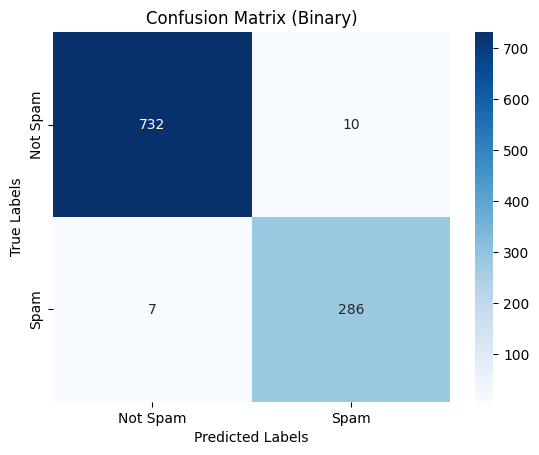

In [ ]:
evaluate_model_binary(model, X_test, Y_test)

#ENSEMBLE OF ELECTRA TRANSFORMERS

In [ ]:
!pip install transformers

In [ ]:
!pip install tensorflow-text

In [ ]:
from keras.layers import concatenate, Flatten

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, TimeDistributed
from transformers import ElectraTokenizer, TFElectraModel


In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalMaxPool1D, Input
from keras.models import Model

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(Email_dataset['Email_text'], Email_dataset['Labels'], train_size=.8, random_state=42, shuffle = True)

Loading the Bert preprocessing and electra Electra Encoder

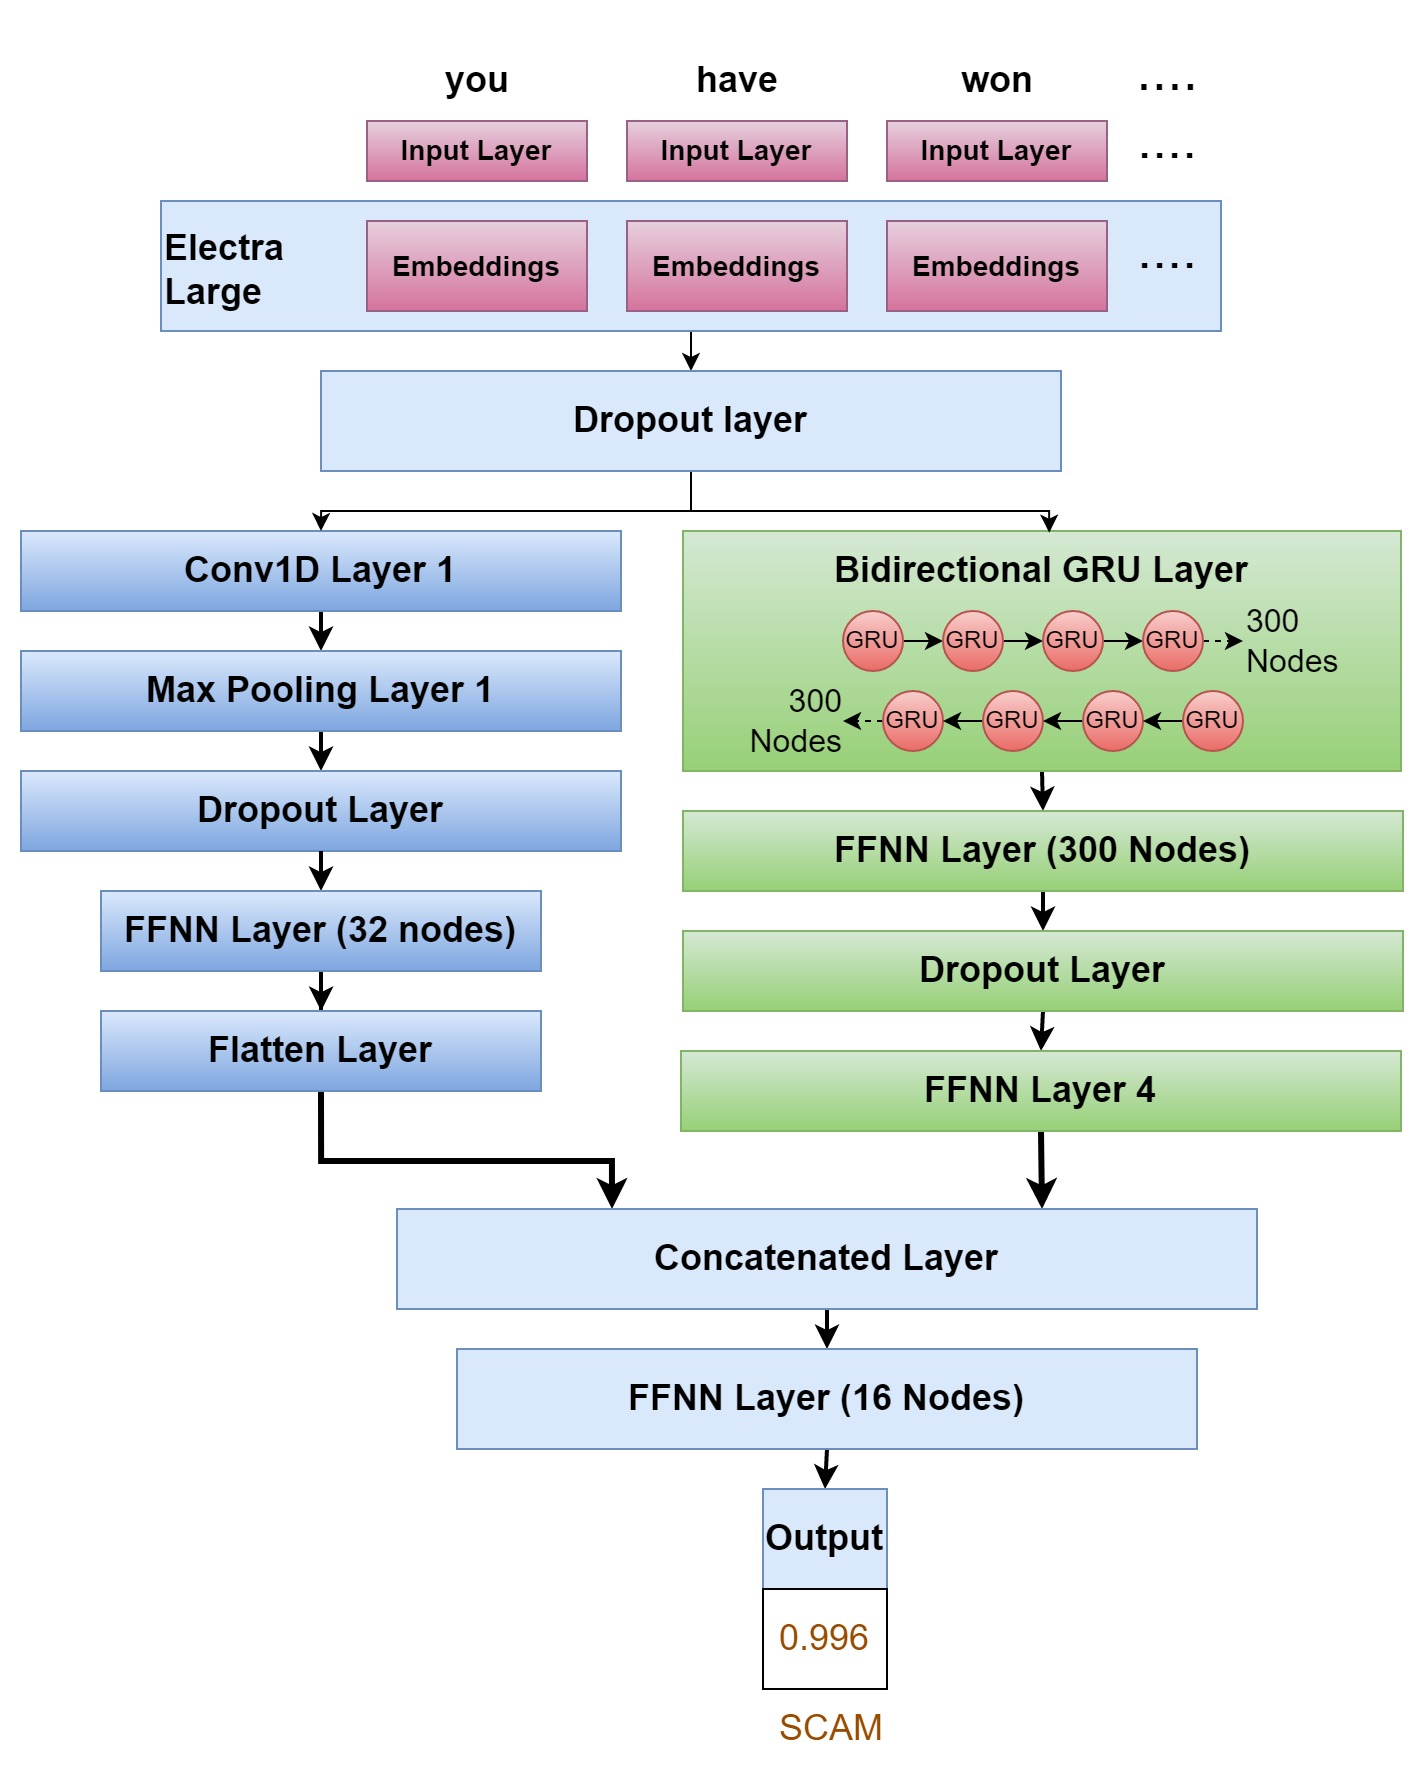

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
electra_encoder = hub.KerasLayer("https://tfhub.dev/google/electra_large/2")


In [ ]:
# Electra layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = electra_encoder(preprocessed_text)

# GRU layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['sequence_output'])
gru1 = Bidirectional(GRU(300,activation='tanh', dropout=0.2, recurrent_dropout=0.2)) (l)
gru2 = Dense(300,activation = 'relu')(gru1)

# CNN Layers
cnn1 = Conv1D(128,8,activation = 'relu' )(l)
cnn2 = MaxPooling1D(2)(cnn1)
cnn3 = Dropout(0.3)(cnn2)
cnn4 = Dense(32, activation = "relu")(cnn3)
cnn5 = Flatten()(cnn4)

merge = concatenate([cnn5,gru2])
dense1 = Dense(16, activation = 'relu')(merge)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dense1)
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
epochs = 100
batch_size = 512 #*tpu_strategy.num_replicas_in_sync
for i in range(epochs):
  history = model.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])
  accr = model.evaluate(X_test,Y_test) 
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  if accr[1] >= 0.980:
    break

33/33 [==============================] - 37s 1s/step - loss: 0.5310 - accuracy: 0.7285 - precision: 0.5833 - recall: 0.1433
Test set
  Loss: 0.531
  Accuracy: 0.729
33/33 [==============================] - 37s 1s/step - loss: 0.4027 - accuracy: 0.8039 - precision: 0.8629 - recall: 0.3652
Test set
  Loss: 0.403
  Accuracy: 0.804
33/33 [==============================] - 37s 1s/step - loss: 0.3408 - accuracy: 0.8763 - precision: 0.8910 - recall: 0.6416
Test set
  Loss: 0.341
  Accuracy: 0.876
33/33 [==============================] - 35s 1s/step - loss: 0.2810 - accuracy: 0.9275 - precision: 0.9129 - recall: 0.8225
Test set
  Loss: 0.281
  Accuracy: 0.928
33/33 [==============================] - 36s 1s/step - loss: 0.2205 - accuracy: 0.9517 - precision: 0.9418 - recall: 0.8840
Test set
  Loss: 0.220
  Accuracy: 0.952
33/33 [==============================] - 36s 1s/step - loss: 0.1244 - accuracy: 0.9498 - precision: 0.9879 - recall: 0.8328
Test set
  Loss: 0.124
  Accuracy: 0.950
33/33 [===

KeyboardInterrupt: ignored

In [ ]:
y_predicted = model.predict(X_test)

33/33 [==============================] - 39s 1s/step


In [ ]:
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
accuracy_score(Y_test, y_predicted)

0.9842922707487531


In [ ]:
print(classification_report(Y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.97      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035

